In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1. 데이터 로드
np.random.seed(20241212)
data = pd.read_csv("KOSPI_valuefactors_from2015to2022.csv")
# data = data.sample(frac=1, random_state=20241212).reset_index(drop=True)
# data = data.sample(frac=1).reset_index(drop=True)

# Default model
`theta`: weigth of each value factor portfolio 


`z`: whether pick 10% from ascending order or descending order

Best z (0=bottom,1=top): [0 0 0 1 0]
Best theta: [0.5 0.  0.5 0.  0. ]
Training total log return (2015~2023): 1.4743570171812275
Test total log return (2015~2023): 1.322338357352243

[Training Year-by-Year Results]
From 2016 to 2017: Log Return = 0.2544, Wealth = 128.96
From 2017 to 2018: Log Return = 0.4854, Wealth = 209.55
From 2018 to 2019: Log Return = 0.1711, Wealth = 248.65
From 2019 to 2020: Log Return = -0.1378, Wealth = 216.65
From 2020 to 2021: Log Return = 0.7866, Wealth = 475.74
From 2021 to 2022: Log Return = 0.2720, Wealth = 624.42
From 2022 to 2023: Log Return = -0.3573, Wealth = 436.82

[Testing Year-by-Year Results]
From 2016 to 2017: Log Return = 0.5842, Wealth = 179.36
From 2017 to 2018: Log Return = -0.1063, Wealth = 161.27
From 2018 to 2019: Log Return = 0.2458, Wealth = 206.21
From 2019 to 2020: Log Return = -0.1349, Wealth = 180.18
From 2020 to 2021: Log Return = 0.8122, Wealth = 405.93
From 2021 to 2022: Log Return = 0.1410, Wealth = 467.38
From 2022 to 2023: Lo

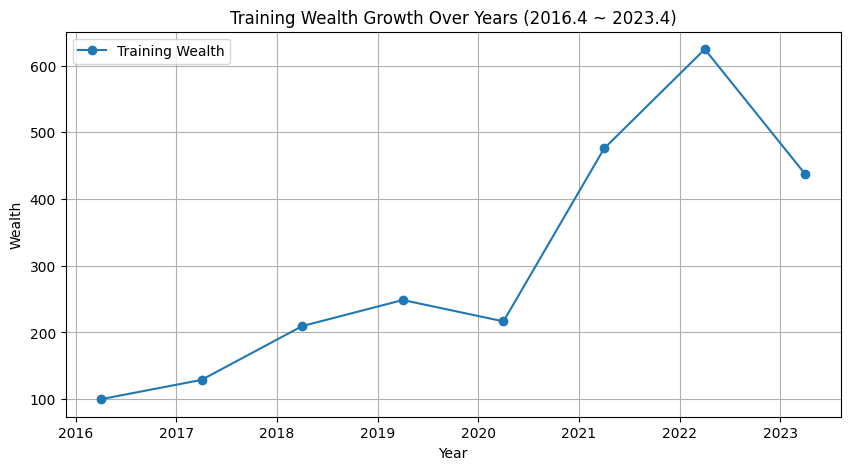

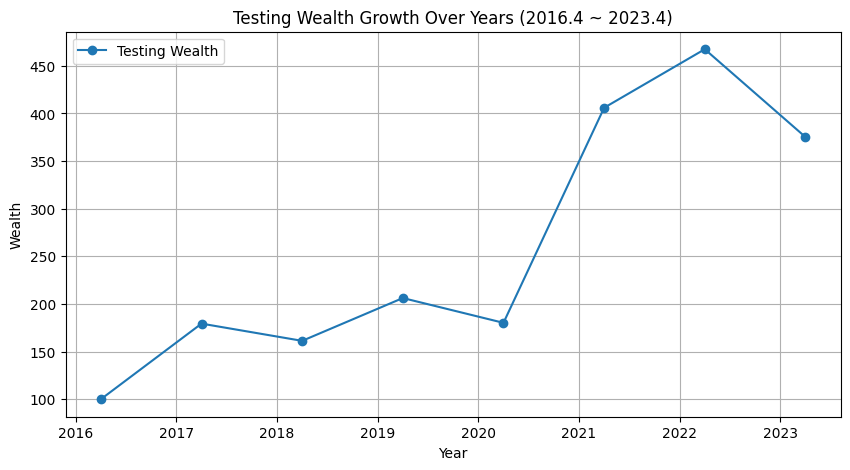

In [2]:
data = data.sample(frac=1).reset_index(drop=True)
# 종목별 분할: 첫 150개 train, 나머지 test
train_data = data.iloc[:150].copy()
test_data = data.iloc[150:].copy()
metrics = ['PBR', 'PER', 'PSR', 'EBIT/EV', 'P_CF']
years = range(2015, 2022)  # 2015 ~ 2023년

def top_10_percent_portfolio(df, metric_year):
    df_sorted = df.sort_values(by=metric_year, ascending=False)
    n = len(df_sorted)
    top_n = int(n * 0.1)
    return df_sorted.head(top_n)

def bottom_10_percent_portfolio(df, metric_year):
    df_sorted = df.sort_values(by=metric_year, ascending=True)
    n = len(df_sorted)
    bot_n = int(n * 0.1)
    return df_sorted.head(bot_n)

# 연도별/지표별 top/bottom 성장률 계산
def calculate_growth_factors(df):
    result = {}
    for y in years:
        for m in metrics:
            metric_col = m + str(y)
            start_col = 'start_price' + str(y)
            end_col = 'end_price' + str(y)
            
            top_df = top_10_percent_portfolio(df, metric_col)
            bot_df = bottom_10_percent_portfolio(df, metric_col)
            
            top_g = (top_df[end_col] / top_df[start_col]).mean()
            bot_g = (bot_df[end_col] / bot_df[start_col]).mean()
            
            result[(y,m)] = (top_g, bot_g)
    return result

train_growth = calculate_growth_factors(train_data)
test_growth = calculate_growth_factors(test_data)

# total_log_return: 주어진 z,theta로 연도별 성장률을 계산 후 로그를 합산
def total_log_return(theta, z, growth_dict):
    log_sum = 0.0
    for y in years:
        year_growths = []
        for i, m in enumerate(metrics):
            top_g, bot_g = growth_dict[(y,m)]
            g = top_g if z[i] == 1 else bot_g
            year_growths.append(g)
        year_growths = np.array(year_growths)
        val = np.dot(theta, year_growths)
        if val <= 0:
            return -1e9
        log_sum += np.log(val)
    return log_sum

def objective_theta(theta, z, growth_dict):
    return -total_log_return(theta, z, growth_dict)

cons = (
    {'type':'eq', 'fun': lambda x: np.sum(x)-1.0}
)
bnds = [(0,1)] * 5
x0 = np.array([0.2]*5)

best_train_log_return = -np.inf
best_theta = None
best_z = None

# z 전수조사 (5차원 이진 -> 32가지)
for mask in range(32):
    z = [(mask >> i) & 1 for i in range(5)]
    z = z[::-1]
    z = np.array(z)
    
    res = minimize(objective_theta, x0, args=(z, train_growth), constraints=cons, bounds=bnds, method='SLSQP')
    if res.success:
        cur_train_log_return = total_log_return(res.x, z, train_growth)
        if cur_train_log_return > best_train_log_return:
            best_train_log_return = cur_train_log_return
            best_theta = res.x.copy()
            best_z = z.copy()

print("Best z (0=bottom,1=top):", best_z)
print("Best theta:", best_theta)
print("Training total log return (2015~2023):", best_train_log_return)

test_log_return = total_log_return(best_theta, best_z, test_growth)
print("Test total log return (2015~2023):", test_log_return)

# 연도별 로그수익 및 자산 가치 변화 계산 함수
def yearly_returns(theta, z, growth_dict, initial_wealth=100):
    wealth = initial_wealth
    year_list = sorted(set(y for (y,m) in growth_dict.keys()))
    log_returns = []
    wealth_values = [wealth]
    for y in year_list:
        year_growths = []
        for i, m in enumerate(metrics):
            top_g, bot_g = growth_dict[(y,m)]
            g = top_g if z[i] == 1 else bot_g
            year_growths.append(g)
        year_growths = np.array(year_growths)
        val = np.dot(theta, year_growths)
        # 연도별 로그수익
        yr_log_return = np.log(val)
        log_returns.append(yr_log_return)
        # 자산 업데이트
        wealth *= val
        wealth_values.append(wealth)
    return year_list, log_returns, wealth_values

# 트레이닝 셋 연도별 결과
train_years, train_logs, train_wealth = yearly_returns(best_theta, best_z, train_growth, initial_wealth=100)
print("\n[Training Year-by-Year Results]")
for y, lr, w in zip(train_years, train_logs, train_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 테스트 셋 연도별 결과
test_years, test_logs, test_wealth = yearly_returns(best_theta, best_z, test_growth, initial_wealth=100)
print("\n[Testing Year-by-Year Results]")
for y, lr, w in zip(test_years, test_logs, test_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 연도별 wealth_values 길이
train_len = len(train_wealth)  # 초기 포함
test_len = len(test_wealth)

# 시간축 재구성
# 시작: 2016.25(2016년 4월)
# 끝: 2024.25(2024년 4월)
# 총 9년치 데이터를 처리하므로 (2015~2023), 초기 포함 10개 점
# 각 점 사이 간격 = 8년/9구간 ≈ 0.8889년
train_x = [2016.25 + i for i in range(train_len)]
test_x = [2016.25 + i for i in range(test_len)]

# 초기 자산가치(100)도 점으로 추가되어 있으므로 train_wealth[0]=100이 2016.25년도 4월에 해당하고,
# 마지막 train_wealth가 2024.25년도 4월에 해당함

plt.figure(figsize=(10,5))
plt.plot(train_x, train_wealth, marker='o', label='Training Wealth')
plt.title('Training Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_x, test_wealth, marker='o', label='Testing Wealth')
plt.title('Testing Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()


# Linear combination of 5 value factor model
`theta`: weigth of each value factors to make a final value factor portfolio 


`z`: whether use reciprocal of each value factor before linear combination with `thetam`

Best z (0=original,1=reciprocal): [0 1 1 0 1]
Best theta: [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
Training total log return (2015~2023): 1.4011488955082814
Test total log return (2015~2023): 0.7206064809865974

[Training Year-by-Year Results]
From 2016 to 2017: Log Return = 0.2066, Wealth = 122.95
From 2017 to 2018: Log Return = 0.4820, Wealth = 199.09
From 2018 to 2019: Log Return = 0.2035, Wealth = 244.02
From 2019 to 2020: Log Return = -0.0445, Wealth = 233.40
From 2020 to 2021: Log Return = 0.8428, Wealth = 542.16
From 2021 to 2022: Log Return = 0.0420, Wealth = 565.40
From 2022 to 2023: Log Return = -0.3312, Wealth = 405.99

[Testing Year-by-Year Results]
From 2016 to 2017: Log Return = 0.4258, Wealth = 153.08
From 2017 to 2018: Log Return = -0.0448, Wealth = 146.37
From 2018 to 2019: Log Return = 0.0197, Wealth = 149.28
From 2019 to 2020: Log Return = -0.1790, Wealth = 124.82
From 2020 to 2021: Log Return = 0.6210, Wealth = 232.28
From 2021 to 2022: Log Return = 0.135

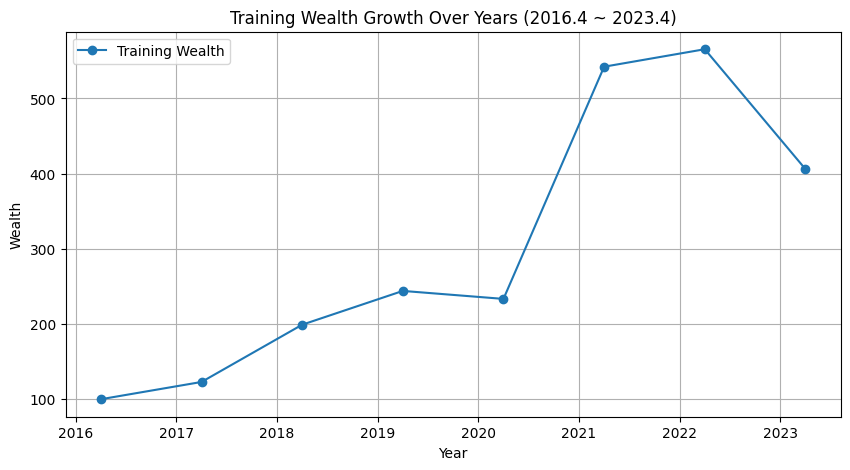

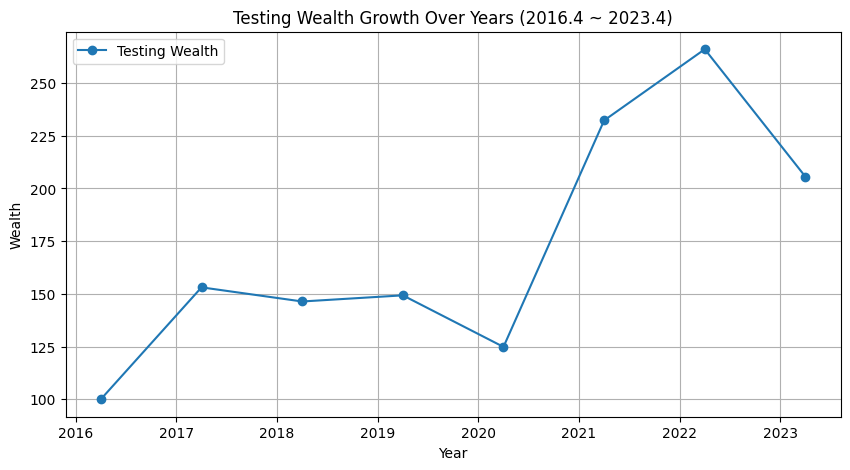

In [3]:
data = data.sample(frac=1).reset_index(drop=True)
train_data = data.iloc[:150].copy()
test_data = data.iloc[150:].copy()

metrics = ['PBR', 'PER', 'PSR', 'EBIT/EV', 'P_CF']
years = range(2015, 2022)  # 2015 ~ 2021년까지 (총 7년치)

# 주어진 z, theta에 대해 특정 데이터셋과 연도에 대한 상위 10% 포트폴리오 수익률 계산 함수
def get_yearly_growth(df, y, metrics, z, theta):
    start_col = 'start_price' + str(y)
    end_col = 'end_price' + str(y)
    
    # 각 종목에 대해 지표 계산
    # z[i] == 0 이면 원래 값 사용, z[i] == 1 이면 역수 사용 (0일 경우 val, 1일 경우 1/val)
    metric_values = []
    for idx, row in df.iterrows():
        vals = []
        for i, m in enumerate(metrics):
            metric_col = m + str(y)
            val = row[metric_col]
            # 역수 계산 시 val이 0일 경우 대비 필요
            if z[i] == 1:
                if val == 0:
                    val = np.inf  # val이 0이면 역수가 무한대인 경우 핸들링
                else:
                    val = 1.0 / val
            vals.append(val)
        vals = np.array(vals)
        
        # theta와 vals의 선형결합
        combined_val = np.dot(theta, vals)
        metric_values.append((idx, combined_val))
        
    # 종합지표 기준 내림차순 정렬
    metric_values.sort(key=lambda x: x[1], reverse=True)
    n = len(metric_values)
    top_n = int(n * 0.1)
    top_indices = [v[0] for v in metric_values[:top_n]]
    top_df = df.loc[top_indices]
    
    # 상위 10% 포트폴리오 성장률 (end/start)
    growth = (top_df[end_col] / top_df[start_col]).mean()
    return growth

# total_log_return: 주어진 z,theta로 연도별 성장률을 계산 후 로그를 합산
def total_log_return(theta, z, df):
    log_sum = 0.0
    for y in years:
        val = get_yearly_growth(df, y, metrics, z, theta)
        if val <= 0 or np.isinf(val) or np.isnan(val):
            return -1e9
        log_sum += np.log(val)
    return log_sum

def objective_theta(theta, z, df):
    # 목적함수는 음의 값으로 설정: maximize total_log_return <=> minimize -total_log_return
    return -total_log_return(theta, z, df)

# 2-norm이 1인 제약조건
def norm_constraint(t):
    return np.sum(t**2) - 1.0

cons = (
    {'type':'eq', 'fun': norm_constraint}  # 2-norm = 1 제약조건
)
# theta에 대한 범위: 특별히 주어지지 않았으나, norm=1이면 음수도 가능하므로 bounds 생략 가능
# bounds = None
x0 = np.array([1.0/np.sqrt(len(metrics))]*len(metrics))  # 초기값: norm 1에 가까운 벡터

best_train_log_return = -np.inf
best_theta = None
best_z = None

# z 전수조사 (5차원 이진 -> 32가지)
for mask in range(32):
    z = [(mask >> i) & 1 for i in range(5)]
    z = z[::-1]
    z = np.array(z)
    
    # SLSQP 최적화
    res = minimize(objective_theta, x0, args=(z, train_data), constraints=cons, method='SLSQP')
    if res.success:
        cur_train_log_return = total_log_return(res.x, z, train_data)
        if cur_train_log_return > best_train_log_return:
            best_train_log_return = cur_train_log_return
            best_theta = res.x.copy()
            best_z = z.copy()

print("Best z (0=original,1=reciprocal):", best_z)
print("Best theta:", best_theta)
print("Training total log return (2015~2023):", best_train_log_return)

test_log_return = total_log_return(best_theta, best_z, test_data)
print("Test total log return (2015~2023):", test_log_return)

def yearly_returns(theta, z, df, initial_wealth=100):
    wealth = initial_wealth
    year_list = sorted(set(years))
    log_returns = []
    wealth_values = [wealth]
    for y in year_list:
        val = get_yearly_growth(df, y, metrics, z, theta)
        yr_log_return = np.log(val)
        log_returns.append(yr_log_return)
        wealth *= val
        wealth_values.append(wealth)
    return year_list, log_returns, wealth_values

# 트레이닝 셋 연도별 결과
train_years, train_logs, train_wealth = yearly_returns(best_theta, best_z, train_data, initial_wealth=100)
print("\n[Training Year-by-Year Results]")
for y, lr, w in zip(train_years, train_logs, train_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 테스트 셋 연도별 결과
test_years, test_logs, test_wealth = yearly_returns(best_theta, best_z, test_data, initial_wealth=100)
print("\n[Testing Year-by-Year Results]")
for y, lr, w in zip(test_years, test_logs, test_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 연도별 wealth_values 길이
train_len = len(train_wealth)  # 초기 포함
test_len = len(test_wealth)

# 시간축 재구성(기존 코드와 동일한 방식)
train_x = [2016.25 + i for i in range(train_len)]
test_x = [2016.25 + i for i in range(test_len)]

plt.figure(figsize=(10,5))
plt.plot(train_x, train_wealth, marker='o', label='Training Wealth')
plt.title('Training Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_x, test_wealth, marker='o', label='Testing Wealth')
plt.title('Testing Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

# Linear combination of 5 value factor model - many random initial points of `theta`
Same as before, but with 50 random initial `theta`s from 5D unit sphere

Best z (0=original,1=reciprocal): [0 1 1 0 1]
Best theta: [ 0.07862543 -0.33181182  0.07617327  0.85833875  0.37572754]
Training total log return (2015~2023): 1.9257546665014447
Test total log return (2015~2023): 0.7510970342898922

[Training Year-by-Year Results]
From 2016 to 2017: Log Return = 0.4971, Wealth = 164.40
From 2017 to 2018: Log Return = 0.4927, Wealth = 269.06
From 2018 to 2019: Log Return = 0.0602, Wealth = 285.75
From 2019 to 2020: Log Return = -0.0195, Wealth = 280.23
From 2020 to 2021: Log Return = 0.8926, Wealth = 684.14
From 2021 to 2022: Log Return = 0.2557, Wealth = 883.44
From 2022 to 2023: Log Return = -0.2529, Wealth = 686.03

[Testing Year-by-Year Results]
From 2016 to 2017: Log Return = 0.3210, Wealth = 137.85
From 2017 to 2018: Log Return = -0.0734, Wealth = 128.09
From 2018 to 2019: Log Return = 0.1543, Wealth = 149.45
From 2019 to 2020: Log Return = -0.1966, Wealth = 122.78
From 2020 to 2021: Log Return = 0.6771, Wealth = 241.64
From 2021 to 2022: Log Retu

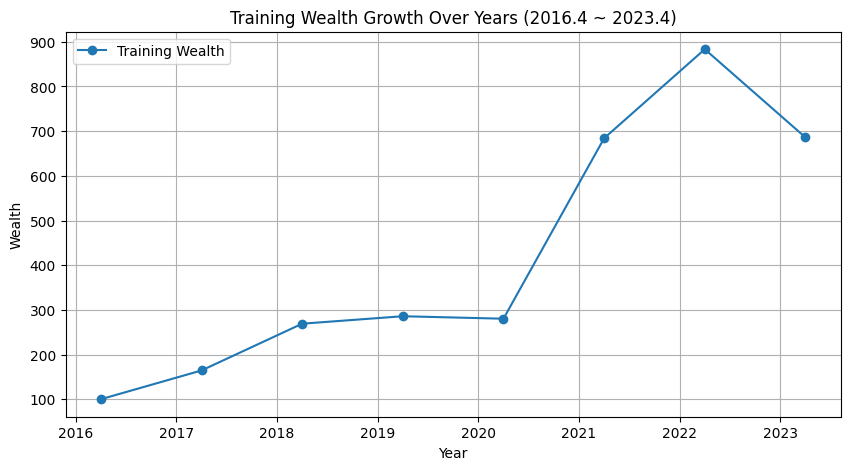

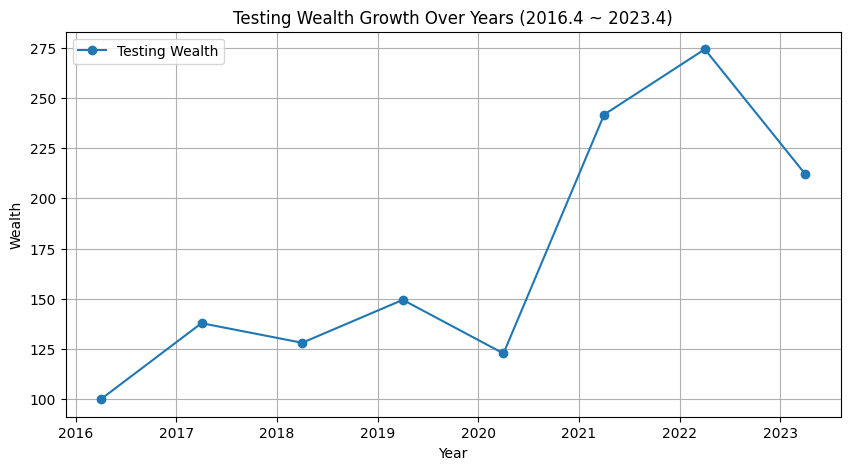

In [ ]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
train_data = data.iloc[:150].copy()
test_data = data.iloc[150:].copy()

metrics = ['PBR', 'PER', 'PSR', 'EBIT/EV', 'P_CF']
years = range(2015, 2022)  # 2015 ~ 2021년까지 (총 7년치)

def get_yearly_growth(df, y, metrics, z, theta):
    start_col = 'start_price' + str(y)
    end_col = 'end_price' + str(y)

    metric_values = []
    for idx, row in df.iterrows():
        vals = []
        for i, m in enumerate(metrics):
            metric_col = m + str(y)
            val = row[metric_col]
            # z[i] == 1이면 역수 사용
            if z[i] == 1:
                if val == 0:
                    val = np.inf
                else:
                    val = 1.0 / val
            vals.append(val)
        vals = np.array(vals)

        combined_val = np.dot(theta, vals)
        metric_values.append((idx, combined_val))

    metric_values.sort(key=lambda x: x[1], reverse=True)
    n = len(metric_values)
    top_n = int(n * 0.1)
    if top_n < 1:
        top_n = 1

    top_indices = [v[0] for v in metric_values[:top_n]]
    top_df = df.loc[top_indices]

    growth = (top_df[end_col] / top_df[start_col]).mean()
    return growth

def total_log_return(theta, z, df):
    log_sum = 0.0
    for y in years:
        val = get_yearly_growth(df, y, metrics, z, theta)
        if val <= 0 or np.isinf(val) or np.isnan(val):
            return -1e9
        log_sum += np.log(val)
    return log_sum

def objective_theta(theta, z, df):
    return -total_log_return(theta, z, df)

# 2-norm = 1 제약조건
def norm_constraint(t):
    return np.sum(t**2) - 1.0

cons = (
    {'type':'eq', 'fun': norm_constraint}
)

# 구면 위에 랜덤 초기값 생성 함수
def random_on_unit_sphere(dim=5, samples=50):
    vecs = np.random.randn(samples, dim)
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs

best_train_log_return = -np.inf
best_theta = None
best_z = None

# z 전수조사 (5차원 이진 -> 32가지)
for mask in range(32):
    z = [(mask >> i) & 1 for i in range(5)]
    z = z[::-1]
    z = np.array(z)
    
    # 여러 개의 초기값 시도 (50개)
    initial_guesses = random_on_unit_sphere(dim=len(metrics), samples=50)
    local_best_log_return = -np.inf
    local_best_theta = None
    
    for x0 in initial_guesses:
        res = minimize(objective_theta, x0, args=(z, train_data), constraints=cons, method='SLSQP')
        if res.success:
            cur_train_log_return = total_log_return(res.x, z, train_data)
            if cur_train_log_return > local_best_log_return:
                local_best_log_return = cur_train_log_return
                local_best_theta = res.x.copy()
    
    # (z)에 대해 가장 좋은 결과와 글로벌 베스트 비교
    if local_best_log_return > best_train_log_return:
        best_train_log_return = local_best_log_return
        best_theta = local_best_theta.copy()
        best_z = z.copy()

print("Best z (0=original,1=reciprocal):", best_z)
print("Best theta:", best_theta)
print("Training total log return (2015~2023):", best_train_log_return)

test_log_return = total_log_return(best_theta, best_z, test_data)
print("Test total log return (2015~2023):", test_log_return)

def yearly_returns(theta, z, df, initial_wealth=100):
    wealth = initial_wealth
    year_list = sorted(set(years))
    log_returns = []
    wealth_values = [wealth]
    for y in year_list:
        val = get_yearly_growth(df, y, metrics, z, theta)
        if val <= 0 or np.isinf(val) or np.isnan(val):
            val = 1e-9  # 안전장치
        yr_log_return = np.log(val)
        log_returns.append(yr_log_return)
        wealth *= val
        wealth_values.append(wealth)
    return year_list, log_returns, wealth_values

# 트레이닝 셋 연도별 결과
train_years, train_logs, train_wealth = yearly_returns(best_theta, best_z, train_data, initial_wealth=100)
print("\n[Training Year-by-Year Results]")
for y, lr, w in zip(train_years, train_logs, train_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 테스트 셋 연도별 결과
test_years, test_logs, test_wealth = yearly_returns(best_theta, best_z, test_data, initial_wealth=100)
print("\n[Testing Year-by-Year Results]")
for y, lr, w in zip(test_years, test_logs, test_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

train_len = len(train_wealth)
test_len = len(test_wealth)

train_x = [2016.25 + i for i in range(train_len)]
test_x = [2016.25 + i for i in range(test_len)]

plt.figure(figsize=(10,5))
plt.plot(train_x, train_wealth, marker='o', label='Training Wealth')
plt.title('Training Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_x, test_wealth, marker='o', label='Testing Wealth')
plt.title('Testing Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

# Linear combination of 5 value factor model+
`theta`: weigth of each value factors to make a final value factor portfolio 

`z`: whether use reciprocal of each value factor before linear combination with `theta`

`r` : take `r` % of stocks, not fixed 10% as before.

Best z (0=original,1=reciprocal): [1 1 1 0 1]
Best r (%): 7
Best theta: [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
Training total log return (2015~2023): 0.9918934416413868
Test total log return (2015~2023): 1.0754188222682295

[Training Year-by-Year Results]
From 2016 to 2017: Log Return = 0.2235, Wealth = 125.04
From 2017 to 2018: Log Return = 0.0485, Wealth = 131.26
From 2018 to 2019: Log Return = 0.1464, Wealth = 151.95
From 2019 to 2020: Log Return = -0.0188, Wealth = 149.12
From 2020 to 2021: Log Return = 0.7176, Wealth = 305.63
From 2021 to 2022: Log Return = 0.1427, Wealth = 352.51
From 2022 to 2023: Log Return = -0.2680, Wealth = 269.63

[Testing Year-by-Year Results]
From 2016 to 2017: Log Return = 0.5919, Wealth = 180.75
From 2017 to 2018: Log Return = 0.0588, Wealth = 191.70
From 2018 to 2019: Log Return = 0.1166, Wealth = 215.40
From 2019 to 2020: Log Return = -0.1357, Wealth = 188.07
From 2020 to 2021: Log Return = 0.7945, Wealth = 416.24
From 2021 to 2022: Log R

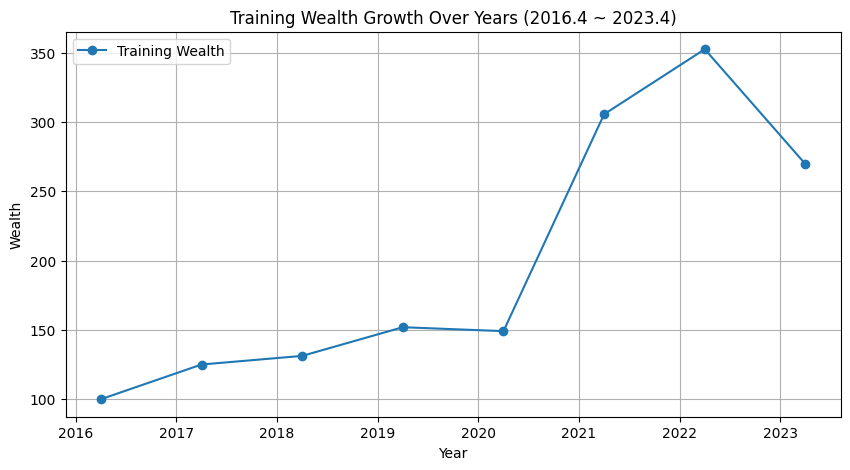

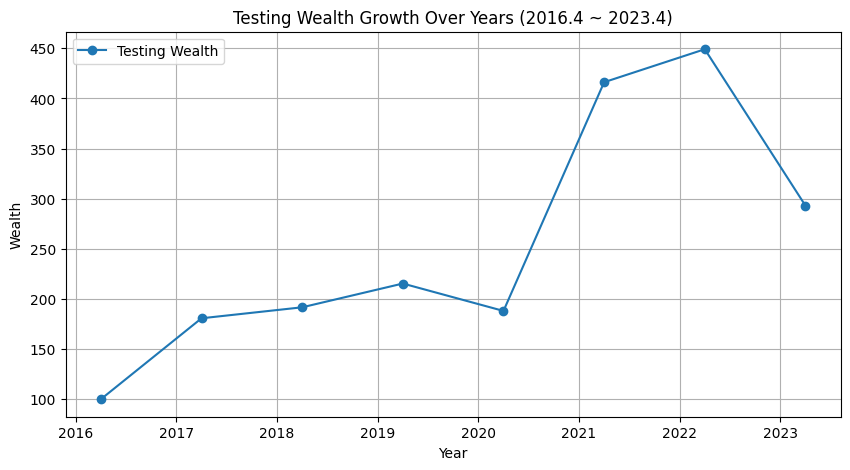

In [4]:
data = data.sample(frac=1).reset_index(drop=True)
train_data = data.iloc[:150].copy()
test_data = data.iloc[150:].copy()

metrics = ['PBR', 'PER', 'PSR', 'EBIT/EV', 'P_CF']
years = range(2015, 2022)  # 2015 ~ 2021
r_list = range(1, 21)  # 1% ~ 20%

# 특정 연도에 대해 z, theta를 이용해 상위 r% 포트폴리오 수익률 계산
def get_yearly_growth(df, y, metrics, z, theta, r):
    start_col = 'start_price' + str(y)
    end_col = 'end_price' + str(y)
    
    metric_values = []
    for idx, row in df.iterrows():
        vals = []
        for i, m in enumerate(metrics):
            metric_col = m + str(y)
            val = row[metric_col]
            # 역수 사용 여부 결정 (z[i]==1이면 역수)
            if z[i] == 1:
                if val == 0:
                    val = np.inf
                else:
                    val = 1.0 / val
            vals.append(val)
        vals = np.array(vals)
        combined_val = np.dot(theta, vals)
        metric_values.append((idx, combined_val))
        
    metric_values.sort(key=lambda x: x[1], reverse=True)
    n = len(metric_values)
    top_n = int(n * (r / 100.0))
    if top_n < 1:
        top_n = 1  # 최소 1종목은 선택
    
    top_indices = [v[0] for v in metric_values[:top_n]]
    top_df = df.loc[top_indices]
    
    growth = (top_df[end_col] / top_df[start_col]).mean()
    if np.isnan(growth) or np.isinf(growth):
        growth = -1e9  # 비정상 값 처리
    return growth

def total_log_return(theta, z, df, r):
    log_sum = 0.0
    for y in years:
        val = get_yearly_growth(df, y, metrics, z, theta, r)
        if val <= 0 or np.isinf(val) or np.isnan(val):
            return -1e9
        log_sum += np.log(val)
    return log_sum

def objective_theta(theta, z, df, r):
    return -total_log_return(theta, z, df, r)

# 2-norm = 1 제약조건
def norm_constraint(t):
    return np.sum(t**2) - 1.0

cons = (
    {'type':'eq', 'fun': norm_constraint}
)
x0 = np.array([1.0/np.sqrt(len(metrics))]*len(metrics))

best_train_log_return = -np.inf
best_theta = None
best_z = None
best_r = None

for mask in range(32):
    z = [(mask >> i) & 1 for i in range(5)]
    z = z[::-1]
    z = np.array(z)
    
    for r in r_list:
        # theta 최적화
        res = minimize(objective_theta, x0, args=(z, train_data, r), constraints=cons, method='SLSQP')
        if res.success:
            cur_train_log_return = total_log_return(res.x, z, train_data, r)
            if cur_train_log_return > best_train_log_return:
                best_train_log_return = cur_train_log_return
                best_theta = res.x.copy()
                best_z = z.copy()
                best_r = r

print("Best z (0=original,1=reciprocal):", best_z)
print("Best r (%):", best_r)
print("Best theta:", best_theta)
print("Training total log return (2015~2023):", best_train_log_return)

test_log_return = total_log_return(best_theta, best_z, test_data, best_r)
print("Test total log return (2015~2023):", test_log_return)


# 연도별 결과 표시
def yearly_returns(theta, z, df, r, initial_wealth=100):
    wealth = initial_wealth
    year_list = sorted(set(years))
    log_returns = []
    wealth_values = [wealth]
    for y in year_list:
        val = get_yearly_growth(df, y, metrics, z, theta, r)
        if val <= 0 or np.isinf(val) or np.isnan(val):
            # 비정상 값이면 로깅하거나 종료
            val = 1e-9
        yr_log_return = np.log(val)
        log_returns.append(yr_log_return)
        wealth *= val
        wealth_values.append(wealth)
    return year_list, log_returns, wealth_values

# 트레이닝 셋 연도별 결과
train_years, train_logs, train_wealth = yearly_returns(best_theta, best_z, train_data, best_r, initial_wealth=100)
print("\n[Training Year-by-Year Results]")
for y, lr, w in zip(train_years, train_logs, train_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 테스트 셋 연도별 결과
test_years, test_logs, test_wealth = yearly_returns(best_theta, best_z, test_data, best_r, initial_wealth=100)
print("\n[Testing Year-by-Year Results]")
for y, lr, w in zip(test_years, test_logs, test_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

# 그래프 출력 (이전과 동일)
train_len = len(train_wealth)
test_len = len(test_wealth)

train_x = [2016.25 + i for i in range(train_len)]
test_x = [2016.25 + i for i in range(test_len)]

plt.figure(figsize=(10,5))
plt.plot(train_x, train_wealth, marker='o', label='Training Wealth')
plt.title('Training Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_x, test_wealth, marker='o', label='Testing Wealth')
plt.title('Testing Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

# Linear combination of 5 value factor model+ - many random initial points of `theta`
Same as before, but with 20 random initial `theta`s from 5D unit sphere

In [ ]:
#이건 너무 오래 걸릴것같아 재현성을 위해 랜덤 시드를 넣었습니다.
data = data.sample(frac=1, random_state=241212).reset_index(drop=True)
train_data = data.iloc[:150].copy()
test_data = data.iloc[150:].copy()

metrics = ['PBR', 'PER', 'PSR', 'EBIT/EV', 'P_CF']
years = range(2015, 2022)  # 2015~2021
r_list = range(1, 21)      # 1%~20%

def get_yearly_growth(df, y, metrics, z, theta, r):
    start_col = 'start_price' + str(y)
    end_col = 'end_price' + str(y)
    
    metric_values = []
    for idx, row in df.iterrows():
        vals = []
        for i, m in enumerate(metrics):
            metric_col = m + str(y)
            val = row[metric_col]
            # 역수 적용
            if z[i] == 1:
                if val == 0:
                    val = np.inf
                else:
                    val = 1.0 / val
            vals.append(val)
        vals = np.array(vals)
        combined_val = np.dot(theta, vals)
        metric_values.append((idx, combined_val))
        
    metric_values.sort(key=lambda x: x[1], reverse=True)
    n = len(metric_values)
    top_n = int(n * (r / 100.0))
    if top_n < 1:
        top_n = 1
    
    top_indices = [v[0] for v in metric_values[:top_n]]
    top_df = df.loc[top_indices]
    
    growth = (top_df[end_col] / top_df[start_col]).mean()
    if np.isnan(growth) or np.isinf(growth):
        growth = -1e9
    return growth

def total_log_return(theta, z, df, r):
    log_sum = 0.0
    for y in years:
        val = get_yearly_growth(df, y, metrics, z, theta, r)
        if val <= 0 or np.isinf(val) or np.isnan(val):
            return -1e9
        log_sum += np.log(val)
    return log_sum

def objective_theta(theta, z, df, r):
    return -total_log_return(theta, z, df, r)

# norm=1 제약조건
def norm_constraint(t):
    return np.sum(t**2) - 1.0

cons = (
    {'type':'eq', 'fun': norm_constraint}
)

# 구면 위에 랜덤 초기값 생성 함수
def random_on_unit_sphere(dim=5, samples=20):
    # 가우시안에서 샘플링 후 노멀라이즈
    vecs = np.random.randn(samples, dim)
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs

best_train_log_return = -np.inf
best_theta = None
best_z = None
best_r = None

z_candidates = []
for mask in range(32):
    z_arr = [(mask >> i) & 1 for i in range(5)]
    z_arr = z_arr[::-1]
    z_arr = np.array(z_arr)
    z_candidates.append(z_arr)

# 전수조사
for z in z_candidates:
    for r in r_list:
        # random restarts: 다수의 초기값 시도
        initial_guesses = random_on_unit_sphere(dim=len(metrics), samples=20)
        local_best_val = -np.inf
        local_best_theta = None
        
        for x0 in initial_guesses:
            # 로컬 최적화
            res = minimize(objective_theta, x0, args=(z, train_data, r), constraints=cons, method='SLSQP', options={'maxiter':500})
            if res.success:
                cur_val = total_log_return(res.x, z, train_data, r)
                if cur_val > local_best_val:
                    local_best_val = cur_val
                    local_best_theta = res.x.copy()
        
        # local_best_val이 global best보다 좋은지 확인
        if local_best_val > best_train_log_return:
            best_train_log_return = local_best_val
            best_theta = local_best_theta.copy()
            best_z = z.copy()
            best_r = r

print("Best z (0=original,1=reciprocal):", best_z)
print("Best r (%):", best_r)
print("Best theta:", best_theta)
print("Training total log return (2015~2023):", best_train_log_return)

test_log_return = total_log_return(best_theta, best_z, test_data, best_r)
print("Test total log return (2015~2023):", test_log_return)

def yearly_returns(theta, z, df, r, initial_wealth=100):
    wealth = initial_wealth
    year_list = sorted(set(years))
    log_returns = []
    wealth_values = [wealth]
    for y in year_list:
        val = get_yearly_growth(df, y, metrics, z, theta, r)
        if val <= 0 or np.isinf(val) or np.isnan(val):
            val = 1e-9
        yr_log_return = np.log(val)
        log_returns.append(yr_log_return)
        wealth *= val
        wealth_values.append(wealth)
    return year_list, log_returns, wealth_values

train_years, train_logs, train_wealth = yearly_returns(best_theta, best_z, train_data, best_r, initial_wealth=100)
print("\n[Training Year-by-Year Results]")
for y, lr, w in zip(train_years, train_logs, train_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

test_years, test_logs, test_wealth = yearly_returns(best_theta, best_z, test_data, best_r, initial_wealth=100)
print("\n[Testing Year-by-Year Results]")
for y, lr, w in zip(test_years, test_logs, test_wealth[1:]):
    print(f"From {y+1} to {y+2}: Log Return = {lr:.4f}, Wealth = {w:.2f}")

train_len = len(train_wealth)
test_len = len(test_wealth)
train_x = [2016.25 + i for i in range(train_len)]
test_x = [2016.25 + i for i in range(test_len)]

plt.figure(figsize=(10,5))
plt.plot(train_x, train_wealth, marker='o', label='Training Wealth')
plt.title('Training Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(test_x, test_wealth, marker='o', label='Testing Wealth')
plt.title('Testing Wealth Growth Over Years (2016.4 ~ 2023.4)')
plt.xlabel('Year')
plt.ylabel('Wealth')
plt.grid(True)
plt.legend()
plt.show()